# Vanilla GAN

- Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define Generator & Discriminator
- layers would be mlp
- Activations except last one are nn.LeakyReLU(0.2)
- BachNorm parameter = 0.8
- Dropout p = 0.5

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(100,256)
        self.block2 = self.make_block(256,512)
        self.block3 = self.make_block(512,1024)
        self.fc1 = nn.Linear(1024, 784)
        self.last_act = nn.Tanh()
        self.dropout = nn.Dropout()
        

    def make_block(self, in_feat, out_feat):
        #### Implement Here ####
        block = [
            nn.Linear(in_feat, out_feat),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(out_feat, 0.8)
        ]

        return nn.Sequential(*block)
    

    def forward(self, z): # [bs, 100]
        #### Implement Here ####
        # Hint : Embedding vector should be resized into image shape after go through network
        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        z = self.dropout(z)
        z = self.fc1(z)
        z = self.last_act(z)
        img = z.view(-1, 1,28,28)

        return img #[bs, 1, 28, 28]

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.dropout = nn.Dropout()
        self.act = nn.LeakyReLU(0.2)
        self.last_act = nn.Sigmoid()
        self.fc1 = nn.Linear(784,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,1)
        
    def forward(self, img):
        #### Implement Here ####
        # Hint : Image should be vectorized before go through network
        x = img.view(-1, 784)
        x = self.dropout(x)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.last_act(self.fc3(x))
        
        return x

In [24]:
# Initialize generator and discriminator
# G = Generator()
D = Discriminator()

In [26]:
from torchsummary import summary
#summary(G, device = 'cpu', batch_size = -1, input_size = (100,))
summary(D, device = 'cpu', batch_size = -1, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


## Define loss & Optimizer & model

In [27]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizer for each network
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0001, betas = (0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0001, betas = (0.5, 0.9999))

## Use MNIST Dataset & DataLoader

In [3]:
train_bs = 64

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_bs, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



torch.Size([64, 1, 28, 28]) tensor([5, 4, 8, 3, 2, 3, 0, 6, 4, 4, 7, 6, 8, 3, 8, 6, 3, 8, 6, 3, 7, 6, 3, 3,
        6, 0, 7, 0, 3, 8, 9, 3, 2, 8, 9, 1, 9, 6, 3, 2, 7, 1, 9, 5, 5, 8, 7, 3,
        7, 8, 4, 8, 7, 4, 2, 9, 8, 4, 4, 9, 4, 0, 4, 1])


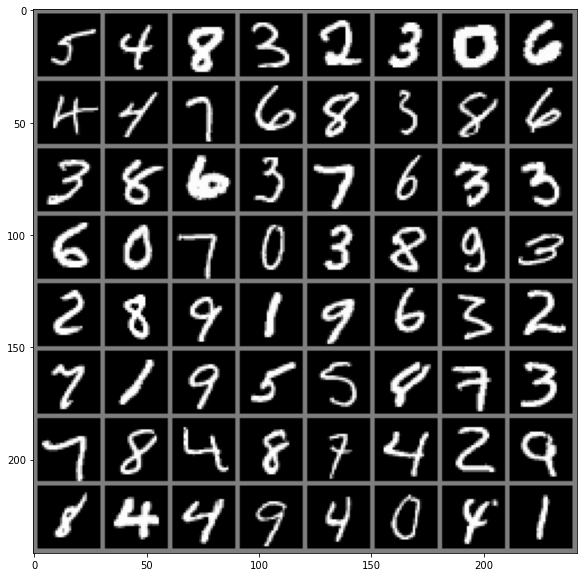

In [4]:
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Start Training

In [29]:
G, D = G.to(device), D.to(device)
os.makedirs("./mlpgan", exist_ok=True)
epochs = 10

[Epoch 1/10] [Batch 0/937] [D loss: 0.711179] [G loss: 0.686418]


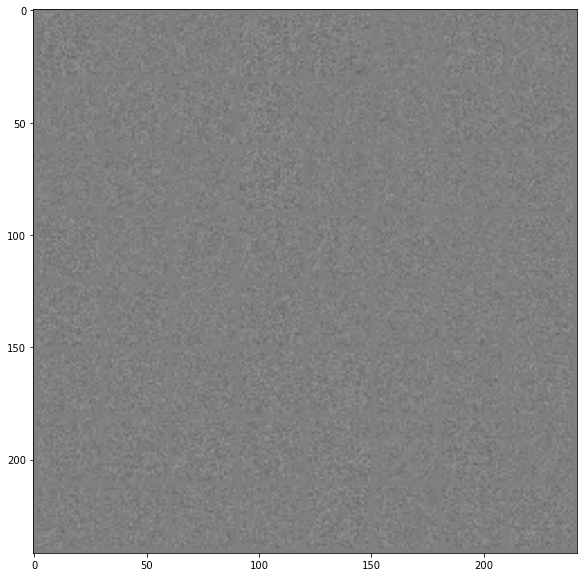

[Epoch 1/10] [Batch 100/937] [D loss: 0.322517] [G loss: 0.797169]
[Epoch 1/10] [Batch 200/937] [D loss: 0.311095] [G loss: 0.938396]
[Epoch 1/10] [Batch 300/937] [D loss: 0.276702] [G loss: 1.304603]
[Epoch 1/10] [Batch 400/937] [D loss: 0.405679] [G loss: 1.679655]
[Epoch 1/10] [Batch 500/937] [D loss: 0.380731] [G loss: 0.927110]
[Epoch 1/10] [Batch 600/937] [D loss: 0.245414] [G loss: 2.461538]
[Epoch 1/10] [Batch 700/937] [D loss: 0.187054] [G loss: 1.354188]
[Epoch 1/10] [Batch 800/937] [D loss: 0.150659] [G loss: 2.384394]
[Epoch 1/10] [Batch 900/937] [D loss: 0.516846] [G loss: 1.906884]
[Epoch 2/10] [Batch 63/937] [D loss: 0.445732] [G loss: 1.118999]
[Epoch 2/10] [Batch 163/937] [D loss: 0.602791] [G loss: 2.137189]
[Epoch 2/10] [Batch 263/937] [D loss: 0.424981] [G loss: 2.200982]
[Epoch 2/10] [Batch 363/937] [D loss: 0.330295] [G loss: 1.892874]
[Epoch 2/10] [Batch 463/937] [D loss: 0.494207] [G loss: 1.099766]
[Epoch 2/10] [Batch 563/937] [D loss: 0.454861] [G loss: 1.2321

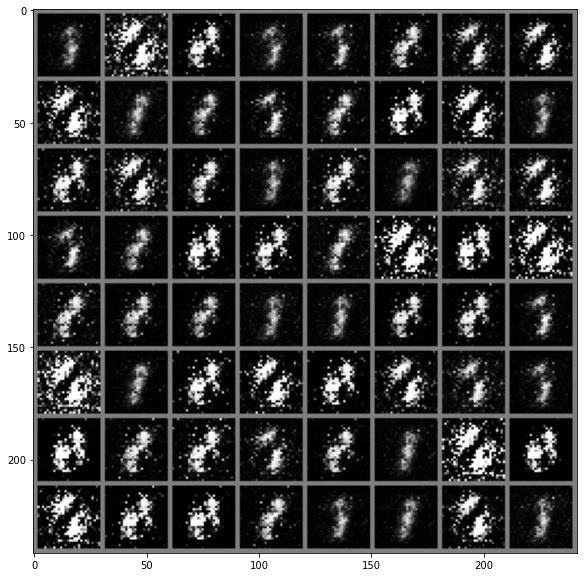

[Epoch 3/10] [Batch 226/937] [D loss: 0.530062] [G loss: 1.135512]
[Epoch 3/10] [Batch 326/937] [D loss: 0.374319] [G loss: 1.498213]
[Epoch 3/10] [Batch 426/937] [D loss: 0.326915] [G loss: 1.458484]
[Epoch 3/10] [Batch 526/937] [D loss: 0.333464] [G loss: 1.665475]
[Epoch 3/10] [Batch 626/937] [D loss: 0.423102] [G loss: 1.206054]
[Epoch 3/10] [Batch 726/937] [D loss: 0.528210] [G loss: 2.252154]
[Epoch 3/10] [Batch 826/937] [D loss: 0.450048] [G loss: 1.686437]
[Epoch 3/10] [Batch 926/937] [D loss: 0.549271] [G loss: 2.604566]
[Epoch 4/10] [Batch 89/937] [D loss: 0.467294] [G loss: 1.261355]
[Epoch 4/10] [Batch 189/937] [D loss: 0.488960] [G loss: 0.942514]
[Epoch 4/10] [Batch 289/937] [D loss: 0.444320] [G loss: 0.900721]
[Epoch 4/10] [Batch 389/937] [D loss: 0.538916] [G loss: 1.444967]
[Epoch 4/10] [Batch 489/937] [D loss: 0.424189] [G loss: 1.103763]
[Epoch 4/10] [Batch 589/937] [D loss: 0.414853] [G loss: 1.470268]
[Epoch 4/10] [Batch 689/937] [D loss: 0.427560] [G loss: 1.5121

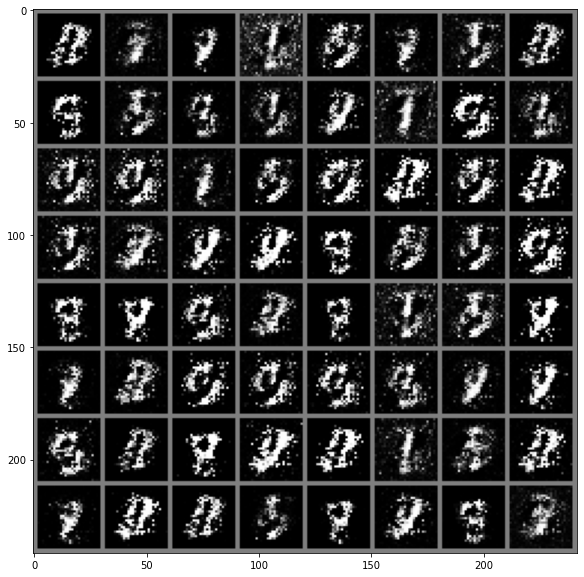

[Epoch 5/10] [Batch 352/937] [D loss: 0.520959] [G loss: 1.269276]
[Epoch 5/10] [Batch 452/937] [D loss: 0.496148] [G loss: 1.082267]
[Epoch 5/10] [Batch 552/937] [D loss: 0.510717] [G loss: 0.879272]
[Epoch 5/10] [Batch 652/937] [D loss: 0.455330] [G loss: 1.117283]
[Epoch 5/10] [Batch 752/937] [D loss: 0.419265] [G loss: 1.555766]
[Epoch 5/10] [Batch 852/937] [D loss: 0.401840] [G loss: 1.094398]
[Epoch 6/10] [Batch 15/937] [D loss: 0.540026] [G loss: 0.884092]
[Epoch 6/10] [Batch 115/937] [D loss: 0.554673] [G loss: 2.145782]
[Epoch 6/10] [Batch 215/937] [D loss: 0.378638] [G loss: 1.391415]
[Epoch 6/10] [Batch 315/937] [D loss: 0.414887] [G loss: 1.461915]
[Epoch 6/10] [Batch 415/937] [D loss: 0.508029] [G loss: 1.221014]
[Epoch 6/10] [Batch 515/937] [D loss: 0.505119] [G loss: 2.092175]
[Epoch 6/10] [Batch 615/937] [D loss: 0.463642] [G loss: 0.906589]
[Epoch 6/10] [Batch 715/937] [D loss: 0.532880] [G loss: 1.037796]
[Epoch 6/10] [Batch 815/937] [D loss: 0.534096] [G loss: 1.9092

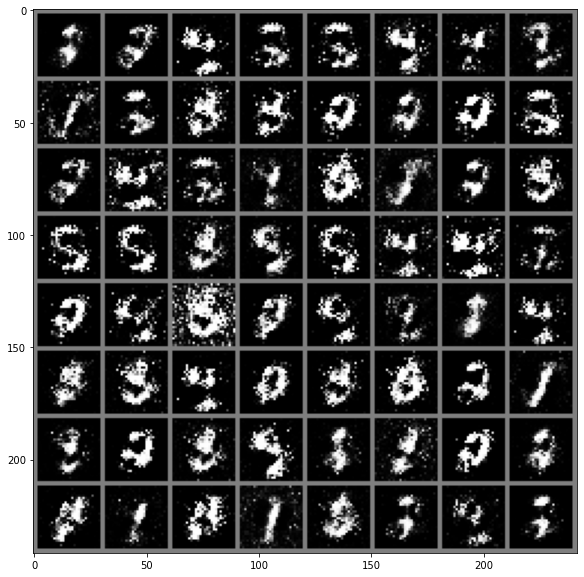

[Epoch 7/10] [Batch 478/937] [D loss: 0.434454] [G loss: 1.433822]
[Epoch 7/10] [Batch 578/937] [D loss: 0.392101] [G loss: 1.549052]
[Epoch 7/10] [Batch 678/937] [D loss: 0.482670] [G loss: 1.750686]
[Epoch 7/10] [Batch 778/937] [D loss: 0.469674] [G loss: 0.920954]
[Epoch 7/10] [Batch 878/937] [D loss: 0.514556] [G loss: 0.816598]
[Epoch 8/10] [Batch 41/937] [D loss: 0.442913] [G loss: 1.163696]
[Epoch 8/10] [Batch 141/937] [D loss: 0.526251] [G loss: 1.105128]
[Epoch 8/10] [Batch 241/937] [D loss: 0.442115] [G loss: 1.482495]
[Epoch 8/10] [Batch 341/937] [D loss: 0.452004] [G loss: 1.028780]
[Epoch 8/10] [Batch 441/937] [D loss: 0.426391] [G loss: 1.111334]
[Epoch 8/10] [Batch 541/937] [D loss: 0.455396] [G loss: 1.239021]
[Epoch 8/10] [Batch 641/937] [D loss: 0.558003] [G loss: 0.973461]
[Epoch 8/10] [Batch 741/937] [D loss: 0.452753] [G loss: 1.014874]
[Epoch 8/10] [Batch 841/937] [D loss: 0.444613] [G loss: 1.465836]
[Epoch 9/10] [Batch 4/937] [D loss: 0.478167] [G loss: 1.226535

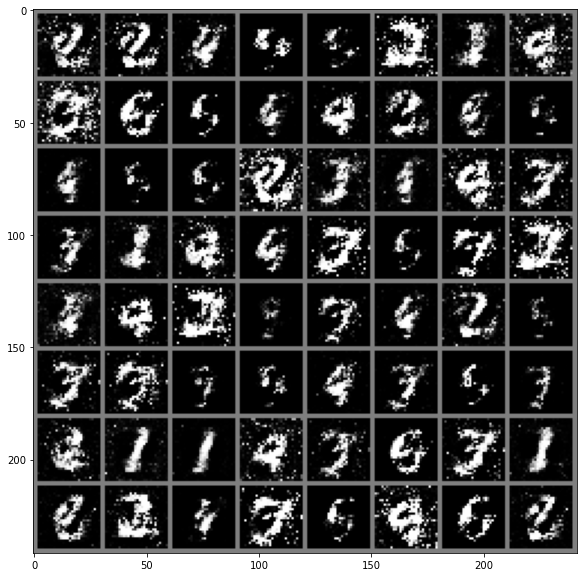

[Epoch 9/10] [Batch 604/937] [D loss: 0.398349] [G loss: 1.618989]
[Epoch 9/10] [Batch 704/937] [D loss: 0.460523] [G loss: 1.393883]
[Epoch 9/10] [Batch 804/937] [D loss: 0.439914] [G loss: 1.740009]
[Epoch 9/10] [Batch 904/937] [D loss: 0.449882] [G loss: 1.307890]
[Epoch 10/10] [Batch 67/937] [D loss: 0.414712] [G loss: 1.481718]
[Epoch 10/10] [Batch 167/937] [D loss: 0.554790] [G loss: 0.976527]
[Epoch 10/10] [Batch 267/937] [D loss: 0.468397] [G loss: 1.078101]
[Epoch 10/10] [Batch 367/937] [D loss: 0.465663] [G loss: 1.945982]
[Epoch 10/10] [Batch 467/937] [D loss: 0.390187] [G loss: 1.504870]
[Epoch 10/10] [Batch 567/937] [D loss: 0.518632] [G loss: 1.229234]
[Epoch 10/10] [Batch 667/937] [D loss: 0.440423] [G loss: 1.346865]
[Epoch 10/10] [Batch 767/937] [D loss: 0.454122] [G loss: 1.335483]
[Epoch 10/10] [Batch 867/937] [D loss: 0.459000] [G loss: 1.111494]


In [33]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        # -----------------
        #  Train Generator
        # -----------------
        real_imgs = real_imgs.to(device)

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], 100))).to(device)

        # Generate a batch of images
        gen_imgs = G(z)
        
        # Loss measures generator's ability to fool the discriminator
        #### implement Loss ####
        ones = torch.ones((gen_imgs.size(0),1)).to(device)
        g_loss = criterion(D(gen_imgs),ones)
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        #### implement Loss ####
        zeros = torch.zeros((gen_imgs.size(0),1)).to(device)
        fake_loss = criterion(D(gen_imgs.detach()),zeros)
        real_loss = criterion(D(real_imgs),ones)
        
        d_loss = (fake_loss + real_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        
        if batches_done % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch+1,epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 2000 == 0:
            save_image(gen_imgs.data, "mlpgan/%06d.png" % batches_done, nrow=8, normalize=True)
            imshow(torchvision.utils.make_grid(gen_imgs.cpu()))